In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import scipy as sp
import tqdm
import scipy.stats

In [2]:
trades = pd.read_csv('../data/2023-06-11/trades.csv')

trades.index = pd.to_datetime(trades.DATE+' '+trades.TIME_M)
del trades['DATE'], trades['TIME_M']

In [3]:
times = trades.index.to_series().astype(int).values*1e-9

In [4]:
events = trades.EX.factorize()[0]#*3 + (np.sign(trades.PRICE.diff().fillna(0))+1).astype(int).values

In [29]:
times

array([1.68654240e+09, 1.68654240e+09, 1.68654240e+09, ...,
       1.68659999e+09, 1.68659999e+09, 1.68659999e+09])

<Axes: >

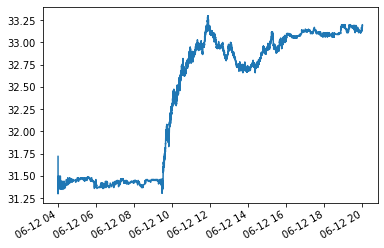

In [139]:
trades[trades.EX!='D'].PRICE.plot()

In [136]:
trades.sort_index().tail(1040).head(20)

,EX,SYM_ROOT,SYM_SUFFIX,TR_SCOND,SIZE,PRICE,TR_STOP_IND,TR_CORR,TR_SEQNUM,TR_ID,TR_SOURCE,TR_RF
2023-06-12 16:59:48.031749376,Q,INTC,NaN,@ TI,85,33.14,NaN,0,6243657,61502,N,NaN
2023-06-12 16:59:51.868560993,Q,INTC,NaN,@ TI,15,33.14,NaN,0,6243670,61503,N,NaN
2023-06-12 16:59:51.868563519,Q,INTC,NaN,@ TI,70,33.14,NaN,0,6243671,61504,N,NaN
2023-06-12 16:59:56.152583120,Q,INTC,NaN,@FTI,30,33.14,NaN,0,6243690,61505,N,NaN
2023-06-12 16:59:56.152585147,Q,INTC,NaN,@FT,100,33.14,NaN,0,6243691,61506,N,NaN
2023-06-12 16:59:56.152914216,P,INTC,NaN,@ TI,48,33.14,NaN,0,6243693,26789,N,NaN
2023-06-12 16:59:59.764187479,P,INTC,NaN,@ TI,3,33.14,NaN,0,6243717,26790,N,NaN
2023-06-12 16:59:59.764187565,P,INTC,NaN,@ TI,1,33.14,NaN,0,6243718,26791,N,NaN
2023-06-12 16:59:59.764187671,P,INTC,NaN,@ TI,3,33.14,NaN,0,6243719,26792,N,NaN
2023-06-12 16:59:59.764187759,P,INTC,NaN,@ TI,10,33.14,NaN,0,6243720,26793,N,NaN


In [32]:
exchanges = trades.EX.unique()

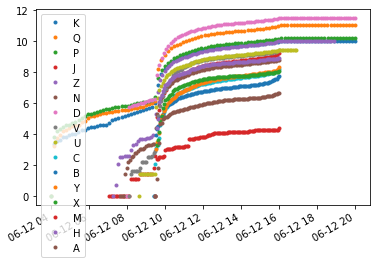

In [36]:
for ex in exchanges:
    ex_times = trades[trades.EX==ex].index
    np.log(pd.Series(1,index=ex_times).cumsum().asof(pd.date_range(ex_times.min(),ex_times.max(),100))).plot(label=ex,linestyle='',marker='.')
plt.legend()

Validation: parametric bootstrap with ~250 datapoints, branching ratio ~0.5

# Quasi EM

\begin{equation}
\log L(\mathcal T;\nu,\alpha,\beta,B) = \sum_{t\in \mathcal T}\log\lambda(t) - \int_0^T \lambda(t)dt
\\= \sum_{j}B_{0,j}\log\nu + \sum_{j}\sum_{i>0} B_{i,j} \left(\log(\alpha) + \beta (t_i-t_j)\right) - T\nu - \sum_{t\in\mathcal T} \int_t^T \alpha\exp\left(-\beta(s-t)\right)ds
\\= \sum_{j}B_{0,j}\log\nu + \sum_{j}\sum_{i>0} B_{i,j} \left(\log(\alpha) + \beta (t_i-t_j)\right) - T\nu - \sum_{t\in\mathcal T} \left[-\frac{\alpha}{\beta}\exp\left(-\beta(s-t)\right)\right]_t^T
\\= \sum_{j}B_{0,j}\log\nu + \sum_{j}\sum_{i>0} B_{i,j} \left(\log(\alpha) + \beta (t_i-t_j)\right) - T\nu + \frac{\alpha}{\beta}\sum_{t\in\mathcal T} \left[\exp\left(-\beta(s-t)\right)\right]_t^T
\\\approx \sum_{j}B_{0,j}\log\nu + \sum_{j}\sum_{i>0} B_{i,j} \left(\log(\alpha) + \beta (t_i-t_j)\right) - T\nu - \frac{\alpha}{\beta}N_T \text{ (quasi-EM approximation)}
\\= \log(\nu) \left(\sum_{j}B_{0,j}\right) + \log(\alpha) \left(\sum_{j}\sum_{i>0} B_{i,j}\right) + \beta \left(\sum_{j}\sum_{i>0} B_{i,j}(t_i-t_j)\right) -\nu (T)- \frac{\alpha}{\beta}\left(N_T\right)
\end{equation}

where
\begin{equation}
B_{i,j} = \frac{1}{\lambda(t_j)} \cdot \begin{cases}\alpha\exp(-\beta(t_j-t_i)), & i>0\\ \nu, & i=0\end{cases}
\end{equation}

implying

\begin{equation}
\nu = \frac{\sum_{j}B_{0,j}}{T} \\
\frac{\alpha}{\beta} = \frac{\sum_{j}\sum_{i>0} B_{i,j}}{N_T} \\
\frac{\alpha}{\beta^2} = -\frac{\sum_{j}\sum_{i>0} B_{i,j}(t_i-t_j)}{N_T}
\end{equation}

i.e.

\begin{equation}
\nu = \frac{\sum_{j}B_{0,j}}{T} \\
\beta = -\frac{\sum_{j}\sum_{i>0} B_{i,j}}{\sum_{j}\sum_{i>0} B_{i,j}(t_i-t_j)} \\
\alpha = -\frac{\left(\sum_{j}\sum_{i>0} B_{i,j}\right)^2}{N_T\sum_{j}\sum_{i>0} B_{i,j}(t_i-t_j)}
\end{equation}


Note that $$\sum_j\sum_i B_{i,j}(t_i-t_j)$$ can be computed in linear time with a backwards and forwards pass, since

\begin{equation}
\sum_j\sum_{i<j} B_{i,j}(t_i-t_j)
\\= \sum_i t_i\sum_{j>i} B_{i,j} - \sum_j t_j\sum_{0<i<j} B_{i,j}
\\= \sum_i t_i\sum_{j>i} \frac{\alpha}{\lambda(t_j)}\exp\left(-\beta(t_j-t_i)\right) - \sum_j t_j\sum_{0<i<j} \frac{\alpha}{\lambda(t_j)}\exp\left(-\beta(t_j-t_i)\right)
\\= \sum_i t_i\sum_{j>i} \frac{\alpha}{\lambda(t_j)}\exp\left(-\beta(t_j-t_i)\right) - \sum_j t_j \frac{\alpha}{\lambda(t_j)}\sum_{0<i<j}\exp\left(-\beta(t_j-t_i)\right)
\\= \text{backwards} - \text{forwards}
\end{equation}

with $B_{i,j}$ computed recursively each time (using the final intensity from the forwards pass as the initial intensity for the backwards pass). There is some risk here of catastrophic cancellation.

## Feature-driven Kernel

\begin{equation}
\log L(\mathcal T;\nu,\alpha,\beta,B) = \sum_{t\in \mathcal T}\log\lambda(t) - \int_0^T \lambda(t)dt
\\= \sum_{j}B_{0,j}\log\nu + \sum_{j}\sum_{i>0} B_{i,j} \left(\log(\alpha) + X_ic + \beta (t_i-t_j)\right) - T\nu - \sum_{i>0} \int_{t_i}^T \alpha e^{X_ic}\exp\left(-\beta(s-t_i)\right)ds
\\= \sum_{j}B_{0,j}\log\nu + \sum_{j}\sum_{i>0} B_{i,j} \left(\log(\alpha) + X_ic + \beta (t_i-t_j)\right) - T\nu - \sum_{i>0} \left[-\frac{\alpha e^{X_ic}}{\beta}\exp\left(-\beta(s-t_i)\right)\right]_{t_i}^T
\\= \sum_{j}B_{0,j}\log\nu + \sum_{j}\sum_{i>0} B_{i,j} \left(\log(\alpha) + X_ic + \beta (t_i-t_j)\right) - T\nu + \frac{\alpha}{\beta}\sum_{i>0} e^{X_ic}\left[\exp\left(-\beta(s-t_i)\right)\right]_{t_i}^T
\\\approx \sum_{j}B_{0,j}\log\nu + \sum_{j}\sum_{i>0} B_{i,j} \left(\log(\alpha) + X_ic + \beta (t_i-t_j)\right) - T\nu - \frac{\alpha}{\beta}\sum_{i>0} e^{X_ic} \text{ (quasi-EM approximation)}
\\= \log(\nu) \left(\sum_{j}B_{0,j}\right) + \log(\alpha) \left(\sum_{j}\sum_{i>0} B_{i,j}\right) + \left(\sum_{j}\sum_{i>0} B_{i,j}X_i\right)c + \beta \left(\sum_{j}\sum_{i>0} B_{i,j}(t_i-t_j)\right) -\nu (T)- \frac{\alpha}{\beta}\sum_{i>0} e^{X_ic}
\end{equation}

where
\begin{equation}
B_{i,j} = \frac{1}{\lambda(t_j)} \cdot \begin{cases}\alpha e^{X_ic}\exp(-\beta(t_j-t_i)), & i>0\\ \nu, & i=0\end{cases}
\end{equation}

implying

\begin{equation}
\nu = \frac{\sum_{j}B_{0,j}}{T} \\
\frac{\partial}{\partial c} = \left(\sum_{j}\sum_{i>0} B_{i,j}X_i\right) - \frac{\sum_{i>0} X_ie^{X_ic}}{\sum_{i>0}e^{X_ic}}\sum_{j}\sum_{i>0} B_{i,j}\\
\frac{\alpha}{\beta} = \frac{\sum_{j}\sum_{i>0} B_{i,j}}{\sum_{i>0}e^{X_ic}} \\
\frac{\alpha}{\beta^2} = -\frac{\sum_{j}\sum_{i>0} B_{i,j}(t_i-t_j)}{N_T}
\end{equation}

i.e.

\begin{equation}
\nu = \frac{\sum_{j}B_{0,j}}{T} \\
\beta = -\frac{\sum_{j}\sum_{i>0} B_{i,j}}{\sum_{j}\sum_{i>0} B_{i,j}(t_i-t_j)} = -\frac{\sum_{j}\frac{\lambda(t_j)-\nu}{\lambda(t_j)}}{\sum_{j}\left(\left(\frac{1}{\lambda(t_j)}\sum_{i>0} \exp\left(-\beta(t_j-t_i)\right)\exp(X_ic)\alpha t_i\right)-\frac{\lambda(t_j)-\nu}{\lambda(t_j)}t_j\right)} \\
\alpha = -\frac{\left(\sum_{j}\sum_{i>0} B_{i,j}\right)^2}{N_T\sum_{j}\sum_{i>0} B_{i,j}(t_i-t_j)} = -\frac{\left(\sum_{j}\frac{\lambda(t_j)-\nu}{\lambda(t_j)}\right)^2}{N_T\sum_{j}\left(\left(\frac{1}{\lambda(t_j)}\sum_{i>0} \exp\left(-\beta(t_j-t_i)\right)\exp(X_ic)\alpha t_i\right)-\frac{\lambda(t_j)-\nu}{\lambda(t_j)}t_j\right)}
\end{equation}


## Univariate

In [85]:
import jax
import jax.numpy as jnp
import numpy as np
import scipy as sp
import scipy.optimize
import tqdm
def em(times, T=None, iters=100, verbose=False):
    times = times.copy() - times[0]
    if T is None:
        T = times[-1]
    N_T = len(times)
        
    nu = np.float64(1.0)
    alpha = np.float64(1.0)
    beta = np.float64(2.0)
    
    for _ in tqdm.trange(iters) if verbose else range(iters):
        #E step
        sum_j_B_0_j = 0
        sum_j_sum_i_B_i_j = 0
        forwards_pass = 0
        backwards_pass = 0
        
        intensities = np.zeros_like(times)
        endo_intensity = 0
        prev_t = 0
        for i,t in enumerate(times):
            endo_intensity *= np.exp(-beta*(t-prev_t))
            intensities[i] = nu+endo_intensity
            B_0_j = nu/intensities[i]
            sum_j_B_0_j += B_0_j
            sum_i_B_i_j = endo_intensity/intensities[i]
            sum_j_sum_i_B_i_j += sum_i_B_i_j
            forwards_pass += t*sum_i_B_i_j
            endo_intensity += alpha
            prev_t = t

        sum_j_B_i_j = 0
        next_t = T
        for i,t in reversed(list(enumerate(times))):
            sum_j_B_i_j *= np.exp(-beta*(next_t-t))
            backwards_pass += t*sum_j_B_i_j
            sum_j_B_i_j += alpha/intensities[i]
            next_t = t
            
            
        constants = np.array([sum_j_B_0_j, sum_j_sum_i_B_i_j, backwards_pass, forwards_pass, T, N_T])
        #constants /= np.std(constants)
        sum_j_B_0_j, sum_j_sum_i_B_i_j, backwards_pass, forwards_pass, T, N_T = constants
        
        #M step
#         def partial_ll(log_nu,log_alpha,log_beta):
#             return log_nu*(sum_j_B_0_j) + log_alpha*sum_j_sum_i_B_i_j + jnp.exp(log_beta)*(backwards_pass-forwards_pass) - jnp.exp(log_nu)*T - jnp.exp(log_alpha-log_beta)*N_T
        
#         print(sum_j_B_0_j, sum_j_sum_i_B_i_j, backwards_pass, forwards_pass, T, N_T)
        
#         starting_partial_ll = partial_ll(log_nu,log_alpha,log_beta)
#         def loss(params):
#             return -partial_ll(*params)/starting_partial_ll
        
#         print(intensities)
#         print(loss([log_nu,log_alpha,log_beta]))
#         print(jax.grad(loss)([log_nu,log_alpha,log_beta]))
#         print(log_nu,log_alpha,log_beta)
        
        
#         constraint = sp.optimize.LinearConstraint([[0,-1,1]], lb=[0], ub=[np.inf], keep_feasible=False)
#         sol=sp.optimize.minimize(loss, jac=jax.grad(loss), x0=[log_nu,log_alpha,log_beta], constraints=constraint, method='trust-constr',options=dict(maxiter=2))
#         print(sol)
#         log_nu,log_alpha,log_beta = sol.x

        assert backwards_pass<forwards_pass, (backwards_pass,forwards_pass)
        nu = sum_j_B_0_j/T
        alpha = -sum_j_sum_i_B_i_j**2/(N_T*(backwards_pass-forwards_pass))
        beta = -sum_j_sum_i_B_i_j/(backwards_pass-forwards_pass)
        #print(nu,alpha,beta)
        
    return nu,alpha,beta

In [55]:
import mpoints.hybrid_hawkes_exp
model = mpoints.hybrid_hawkes_exp.HybridHawkesExp(1,1,[0],[0])

In [38]:
model.estimate_hawkes_parameters(times,np.zeros_like(times,dtype=int),np.zeros_like(times,dtype=int),times[0],times[-1])

(   message: Multiple messages because parallel estimation
    success: True
     status: -999
        fun: -1542538.357981156
          x: [ 1.800e+00  3.436e+03  5.271e+03]
        nit: 26
  successes: [True]
   statuses: [2]
   messages: ['Converged (|x_n-x_(n-1)| ~= 0)']
       jacs: [array([ 1.797e-02, -1.639e-06,  1.428e-08])]
      hesss: []
       nfev: 95,
 array([2.58538576, 1.48987182, 2.46547522]),
 'random ')

In [59]:
model.base_rates = np.array([0.5],dtype=np.float64)
model.impact_coefficients = np.array([[[1]]],dtype=np.float64)
model.decay_coefficients = np.array([[[2]]],dtype=np.float64)
model.transition_probabilities = np.array([[[1]]],dtype=np.float64)

samples = np.array([em(model.simulate(0,500)[0],iters=5) for _ in tqdm.trange(100,position=0,leave=True)])

for i,var in enumerate((model.base_rates, model.impact_coefficients, model.decay_coefficients)):
    print(np.quantile(samples[:,i],[0.025,0.5,0.975]), var)

In [81]:
nu,alpha,beta = em(times,iters=5,verbose=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.89s/it]


In [82]:
#https://math.stackexchange.com/a/4498377
expected_number_events = nu*(times[-1]-times[0])/(1-alpha/beta) + (alpha*nu/(alpha-beta)**2)*(np.exp(-(times[-1]-times[0])*(beta-alpha))-1)
expected_number_events, len(times)

(297793.9936200842, 297795)

# Multivariate

\begin{equation}
\log L(\mathcal T;\nu,\alpha,\beta,B) \approx \sum_{e}\left(\log(\nu_e) \left(\sum_{j}B_{0,j} \delta_{e,e_j}\right) -\nu_e (T) + \sum_{e'} \left(\log(\alpha_{e',e}) \left(\sum_{j}\sum_{i>0} B_{i,j}\delta_{e',e_i}\delta_{e,e_j}\right) + \beta_{e',e} \left(\sum_{j}\sum_{i>0} B_{i,j}(t_i-t_j)\delta_{e',e_i}\delta_{e,e_j}\right)- \frac{\alpha_{e',e}}{\beta_{e',e}}\sum_i \delta_{e',e_i}\right)\right)
\end{equation}

where
\begin{equation}
B_{i,j} = \frac{1}{\lambda_{e_j}(t_j)} \cdot \begin{cases}\alpha_{e_i,e_j}\exp(-\beta_{e_i,e_j}(t_j-t_i)), & i>0\\ \nu_{e_j}, & i=0\end{cases}
\end{equation}

so
\begin{equation}
\nu_e = \frac{\sum_{j}B_{0,j} \delta_{e,e_j}}{T} \\
\alpha_{e',e} = -\frac{\left(\sum_{j}\sum_{i>0} B_{i,j}\delta_{e',e_i}\delta_{e,e_j}\right)^2}{\left(\sum_i \delta_{e',e_i}\right)\left(\sum_{j}\sum_{i>0} B_{i,j}(t_i-t_j)\delta_{e',e_i}\delta_{e,e_j}\right)} \\
\beta_{e',e} = -\frac{\sum_{j}\sum_{i>0} B_{i,j}\delta_{e',e_i}\delta_{e,e_j}}{\sum_{j}\sum_{i>0} B_{i,j}(t_i-t_j)\delta_{e',e_i}\delta_{e,e_j}}
\end{equation}

In [77]:
np.vstack([[1,2,9],[3,4,5]])

array([[1, 2, 9],
       [3, 4, 5]])

In [2]:
import scipy as sp
import scipy.stats
(sp.stats.gaussian_kde([0,1,2,3,4])).integrate_box_1d(0,1)

0.16166463163308056

In [24]:
x = (lambda x : 500*0.5*(1+np.sin(0.8*(x-0.5)*np.pi)))(np.random.uniform(size=500))

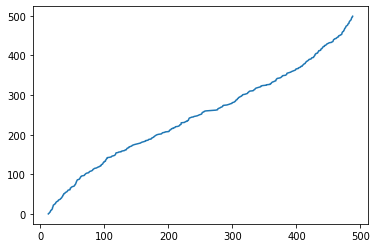

In [27]:
plt.plot(sorted(x),np.arange(len(x)))

- Reflecting points (or see literature)
- Simulation
- State-dependent
- Scaling to more data, probably not more than a week, may need to compare splines to kde

/var/folders/5l/jdr1h_pn3x3_7nt8kgthzmv00000gn/T/ipykernel_12742/1027779557.py:11: RuntimeWarning: invalid value encountered in log
  children = (parents + -(1/b)*np.log(a/(b*np.log(increments)+a)))[increments>np.exp(-a/b)]


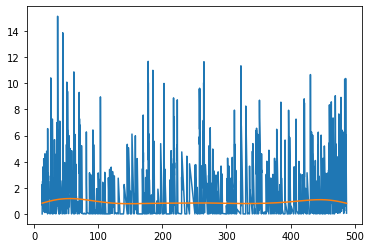

In [15]:
import jax.flatten_util


def get_samples():
    parents = (lambda x : 500*0.5*(1+np.sin(0.8*(x-0.5)*np.pi)))(np.random.uniform(size=500))
    samples = set(parents)
    #plt.plot(sorted(samples),np.arange(len(samples)))
    a,b=5,6
    while True:
        increments = np.random.uniform(size=len(parents))
        children = (parents + -(1/b)*np.log(a/(b*np.log(increments)+a)))[increments>np.exp(-a/b)]
        children = children[children<500]
        samples = samples.union(set(children))
        if len(children)==0:
            break
        parents = children
    samples = np.array(sorted(samples))
    return samples

kernel = CompositeKernel([ExponentialHawkesKernel(1.0,1.0),SmoothingKernel(1.0)])
def parametric_bootstrap():
    samples = get_samples()
    kernel.em(0,500,samples)
    return jax.flatten_util.ravel_pytree(kernel.get_params())[0]

example_points = get_samples()
kernel.em(0,500,example_points)
plt.plot(example_points,kernel.components[0].get_intensities(0,500,example_points))
plt.plot(example_points,kernel.components[1].get_intensities(0,500,example_points))

plt.show()

In [4]:
samples = [parametric_bootstrap() for _ in tqdm.trange(100)]

  0%|                                                                                                                                                                                                                 | 0/100 [00:00<?, ?it/s]/var/folders/5l/jdr1h_pn3x3_7nt8kgthzmv00000gn/T/ipykernel_12742/2075637485.py:11: RuntimeWarning: invalid value encountered in log
  children = (parents + -(1/b)*np.log(a/(b*np.log(increments)+a)))[increments>np.exp(-a/b)]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:18:01<00:00, 46.81s/it]


In [8]:
np.quantile(samples,[0.025,0.5,0.975],axis=0)

array([[2.97686946, 4.86980138, 0.85182428],
       [3.52048159, 6.05003762, 0.95928574],
       [3.91822296, 7.10279285, 1.0511374 ]])

TypeError: simulate() missing 1 required positional argument: 'time_end'

In [40]:
import jax.flatten_util
import sys
sys.path.append('../code/')
import fast_em_classes
import numpy as np

import mpoints.hybrid_hawkes_exp
model = mpoints.hybrid_hawkes_exp.HybridHawkesExp(1,1,[0],[0])
model.base_rates = np.array([1],dtype=np.float64)
model.impact_coefficients = np.array([[[5]]],dtype=np.float64)
model.decay_coefficients = np.array([[[6]]],dtype=np.float64)
model.transition_probabilities = np.array([[[1]]],dtype=np.float64)

def get_samples():
    return model.simulate(0,500)[0].reshape(-1)

kernel = fast_em_classes.CompositeKernel([fast_em_classes.ExponentialHawkesKernel(1.0,1.0),fast_em_classes.SmoothingKernel(1.0)])
def parametric_bootstrap():
    samples = get_samples()
    kernel.em(0,500,samples)
    return jax.flatten_util.ravel_pytree(kernel.get_params())[0]

# plt.plot(samples,kernel.components[0].get_intensities(0,500,samples))
# plt.plot(samples,kernel.components[1].get_intensities(0,500,samples))

# plt.show()


In [43]:
[parametric_bootstrap() for _ in tqdm.trange(5)]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:50<00:00, 70.07s/it]


[Array([5.231594 , 6.648819 , 1.1805534], dtype=float32),
 Array([5.248033 , 6.4647083, 1.0643648], dtype=float32),
 Array([4.6290526, 5.797114 , 1.0470414], dtype=float32),
 Array([5.0111256 , 6.106792  , 0.93388265], dtype=float32),
 Array([4.74518   , 5.613333  , 0.99561036], dtype=float32)]

In [45]:
[print(parametric_bootstrap()) for _ in tqdm.trange(5)]

[autoreload of fast_em_classes failed: Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Library/Frameworks/P

[4.952623  5.9897785 1.118631 ]


 40%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 2/5 [01:12<01:44, 34.89s/it]

[5.1780562 6.2213807 1.0686644]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 3/5 [01:43<01:06, 33.22s/it]

[4.790776  5.7645526 1.1219528]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 4/5 [02:04<00:28, 28.60s/it]

[4.8297353 5.834975  0.8798609]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:07<00:00, 37.48s/it]

[5.051428  6.208271  1.2393265]


[None, None, None, None, None]

In [46]:
import jax.flatten_util
import sys
sys.path.append('../code/')
import fast_em_classes
import numpy as np

import mpoints.hybrid_hawkes_exp
model = mpoints.hybrid_hawkes_exp.HybridHawkesExp(1,1,[0],[0])
model.base_rates = np.array([1],dtype=np.float64)
model.impact_coefficients = np.array([[[5]]],dtype=np.float64)
model.decay_coefficients = np.array([[[6]]],dtype=np.float64)
model.transition_probabilities = np.array([[[1]]],dtype=np.float64)

def get_samples():
    return model.simulate(0,500)[0].reshape(-1)

kernel = fast_em_classes.CompositeKernel([fast_em_classes.ExponentialHawkesKernel(1.0,1.0),fast_em_classes.ConstantKernel(1.0),*[fast_em_classes.MononomialExogenousKernel(1.0,n) for n in range(1,6)]])
def parametric_bootstrap():
    samples = get_samples()
    kernel.em(0,500,samples)
    return jax.flatten_util.ravel_pytree(kernel.get_params())[0]

# plt.plot(samples,kernel.components[0].get_intensities(0,500,samples))
# plt.plot(samples,kernel.components[1].get_intensities(0,500,samples))

# plt.show()


[autoreload of fast_em_classes failed: Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Library/Frameworks/P

In [47]:
[print(parametric_bootstrap()) for _ in tqdm.trange(5)]

 20%|████████████████████████████████████████▍                                                                                                                                                                 | 1/5 [02:10<08:40, 130.25s/it]

[5.3644614e+00 6.6309657e+00 1.0167964e+00 3.1779194e-07 2.5620374e-12
 1.7121086e-16 1.6131555e-19 1.5828190e-21]



KeyboardInterrupt



In [14]:
samples_homogenous = [parametric_bootstrap() for _ in tqdm.trange(100)]
np.quantile(samples_homogenous,[0.025,0.5,0.975],axis=0)



  0%|                                                                                                                                                                                                                 | 0/100 [00:00<?, ?it/s]/var/folders/5l/jdr1h_pn3x3_7nt8kgthzmv00000gn/T/ipykernel_12742/3062057355.py:11: RuntimeWarning: invalid value encountered in log
  children = (parents + -(1/b)*np.log(a/(b*np.log(increments)+a)))[increments>np.exp(-a/b)]


  1%|██                                                                                                                                                                                                       | 1/100 [00:23<38:35, 23.39s/it]

  2%|████                                                                                                                                                                                                     | 2/100 [00:35<27:44, 16.99s/it]

  3%|██████                                           

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 63/100 [14:03<06:49, 11.06s/it]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 64/100 [14:11<06:02, 10.08s/it]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 65/100 [14:23<06:18, 10.83s/it]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 66/100 [14:33<05:51, 10.34s/it]

 67%|███████████████████████████████████

array([[2.57913011e+01, 2.58385461e+01, 2.01053558e-03],
       [3.11089115e+01, 3.11423702e+01, 2.05313426e-03],
       [3.77805568e+01, 3.78689060e+01, 6.04675831e-03]])

\begin{equation}
\log(\alpha_{e',e}) \left(\sum_{j}\sum_{i>0} \frac{w_j}{\lambda_j}\alpha e^{-\beta(t_j-t_i)}\delta_{e',e_i}\delta_{e,e_j}\right) + \beta_{e',e} \left(\sum_{j}\sum_{i>0} \frac{w_j}{\lambda_j}\alpha e^{-\beta(t_j-t_i)}(t_i-t_j)\delta_{e',e_i}\delta_{e,e_j}\right)- \frac{\alpha_{e',e}}{\beta_{e',e}}\sum_i \delta_{e',e_i} \\
= \log(\alpha_{e',e}) \left(\sum_{j}\frac{w_j}{\lambda_j}\alpha \sum_{i>0} e^{-\beta(t_j-t_i)}\delta_{e',e_i}\delta_{e,e_j}\right) + \beta_{e',e} \left(\sum_{j}\sum_{i>0} \frac{w_j}{\lambda_j}\alpha e^{-\beta(t_j-t_i)}(t_i-t_j)\delta_{e',e_i}\delta_{e,e_j}\right)- \frac{\alpha_{e',e}}{\beta_{e',e}}\sum_i \delta_{e',e_i}
\end{equation}

In [151]:
sim[0][-10:]

array([486.84596048, 486.98631616, 487.61428834, 492.92306994,
       494.16925102, 495.37079563, 495.61058112, 496.15892385,
       497.50252495, 498.95528401])

In [296]:
kernel = CompositeKernel([ExponentialHawkesKernel(1.0,2.0),ConstantKernel(0.5)])

In [288]:
kernel=CompositeKernel([ConstantKernel(np.random.exponential()) for _ in range(1)])

In [607]:
kernel

CompositeKernel([ExponentialHawkesKernel([[8.56546813]],[[13.4401909]]), ConstantKernel([0.11969015])])

True

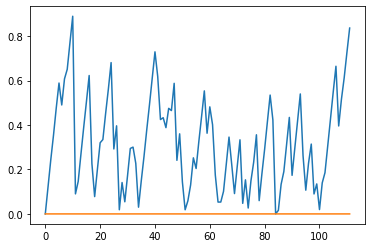

(array([52., 29., 30., 18., 18., 33., 33., 18., 29., 46.]),
 array([ 12.46247092,  59.85839561, 107.25432031, 154.65024501,
        202.0461697 , 249.4420944 , 296.8380191 , 344.23394379,
        391.62986849, 439.02579319, 486.42171788]),
 <BarContainer object of 10 artists>)

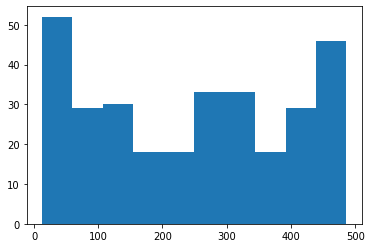

In [532]:
plt.hist(samples)

In [469]:
import sympy
a=sympy.Symbol('a')
b=sympy.Symbol('b')
t=sympy.Symbol('t')
u=sympy.Symbol('u')
x=sympy.Symbol('x')

In [507]:
sympy.solve(sympy.integrate(a*sympy.exp(-b*x),(x,0,t))+sympy.log(u),t)

[Piecewise((-log(u)/a, Eq(b, 0) | (b >= oo) | (b <= -oo)), (nan, True)),
 Piecewise((log(a/(a + b*log(u)))/b, (b > -oo) & (b < oo) & Ne(b, 0)), (nan, True))]

(array([16., 23., 21., 15.,  9.,  6.,  6.,  2.,  0.,  2.]),
 array([1.48473720e-03, 2.04218717e-01, 4.06952697e-01, 6.09686677e-01,
        8.12420657e-01, 1.01515464e+00, 1.21788862e+00, 1.42062260e+00,
        1.62335658e+00, 1.82609056e+00, 2.02882454e+00]),
 <BarContainer object of 10 artists>)

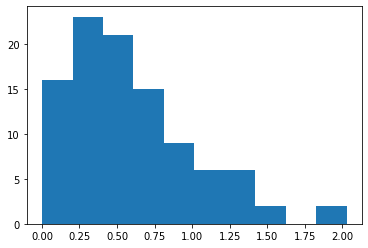

In [466]:
plt.hist(np.log(1-np.log(np.random.uniform(size=100))))

/var/folders/5l/jdr1h_pn3x3_7nt8kgthzmv00000gn/T/ipykernel_1116/3631539476.py:1: RuntimeWarning: invalid value encountered in log
  plt.hist(-np.log(1+np.log(np.random.uniform(size=100))))


(array([26., 13.,  7.,  2.,  3.,  4.,  2.,  2.,  0.,  1.]),
 array([6.52467350e-04, 3.36322168e-01, 6.71991868e-01, 1.00766157e+00,
        1.34333127e+00, 1.67900097e+00, 2.01467067e+00, 2.35034037e+00,
        2.68601007e+00, 3.02167977e+00, 3.35734947e+00]),
 <BarContainer object of 10 artists>)

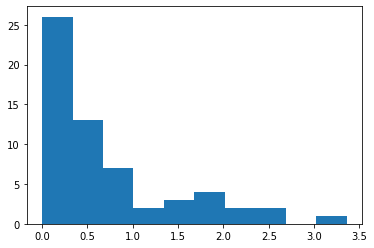

In [461]:
plt.hist(-np.log(1+np.log(np.random.uniform(size=100))))

In [458]:
sympy.solve(sympy.integrate(a*sympy.exp(-b*t),t)+sympy.log(u),t)

[Piecewise((-log(u)/a, Eq(b, 0)), (nan, True)),
 Piecewise((log(a/(b*log(u)))/b, Ne(b, 0)), (nan, True))]

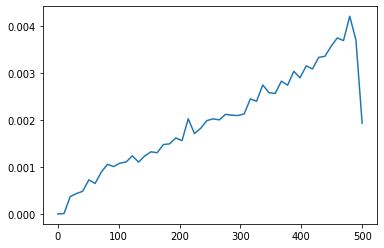

In [440]:
x = np.linspace(0,500)
plt.plot(x,sp.stats.gaussian_kde(samples,bw_method=0.01)(x))

In [289]:
kernel.em(0,500,x)

True

In [290]:
[c.nu for c in kernel.components]

[array([0.98])]

In [297]:
kernel.em(0,500,*sim)

True

In [265]:
len(x)/500

0.98

In [299]:
[c for c in kernel.components]

[ExponentialHawkesKernel([[1.09906186]],[[2.71738943]]),
 ConstantKernel([0.58006079])]

In [246]:
x=np.random.exponential(size=700).cumsum()
x=x[x<500]
x

array([  0.72695656,   0.75318707,   0.76555746,   2.39528649,
         3.99167663,   4.15838903,   4.88334147,   4.89520327,
         5.35247895,   5.4809588 ,   5.53938069,   5.80404773,
         6.13123979,   7.53393245,   9.19238818,   9.22173993,
        10.86986712,  11.16076309,  13.22138623,  13.66309199,
        14.62624691,  14.64473905,  16.31028391,  18.28446124,
        20.78071421,  20.88640155,  22.90933105,  23.50463865,
        24.59105624,  25.5057976 ,  30.7536105 ,  31.29838409,
        32.01257672,  32.1082154 ,  32.57739229,  32.67425665,
        34.12670979,  34.86467873,  36.30204627,  45.68128621,
        48.23407818,  51.1967446 ,  51.47360524,  51.72130526,
        52.16378233,  53.06671973,  55.37689087,  56.20139637,
        57.62632111,  57.72844196,  60.26196226,  60.27756254,
        61.4629618 ,  61.67524522,  61.96221401,  64.42843298,
        65.14728346,  65.42611857,  65.45826121,  66.28574834,
        66.4653655 ,  67.39573387,  67.7436445 ,  68.23

In [291]:
kernel.em(0,500,*sim)

True

In [292]:
kernel = CompositeKernel([ExponentialHawkesKernel(1.0,2.0),ConstantKernel(0.5)])
kernel.em(0,500,*sim)

True

In [293]:
[c for c in kernel.components]

In [119]:
sim=model.simulate(0,500)[:2]

In [134]:
kernel = ConstantKernel(1.0)
kernel.em(0,500,sim)

nu [[0.002]]
nu [[0.002]]


True

In [300]:
model = mpoints.hybrid_hawkes_exp.HybridHawkesExp(1,1,[0],[0])
model.base_rates = np.array([0.5],dtype=np.float64)
model.impact_coefficients = np.array([[[1]]],dtype=np.float64)
model.decay_coefficients = np.array([[[2]]],dtype=np.float64)
model.transition_probabilities = np.array([[[1]]],dtype=np.float64)

kernel = CompositeKernel([ExponentialHawkesKernel(1.0,1.0),ConstantKernel(1.0)])

samples = [(kernel.em(0,500,*model.simulate(0,500)[:2]),np.hstack([*map(np.squeeze,(kernel.components[1].nu,kernel.components[0].alpha,kernel.components[0].beta))]))[1] for _ in tqdm.trange(100,position=0,leave=True)]
nus,alphas,betas = map(lambda x : np.quantile(x,[0.025,0.5,0.975],axis=0),map(np.array,zip(*samples)))

for x,y in list(zip(nus.reshape(3,-1).T,model.base_rates.reshape(-1))) + list(zip(alphas.reshape(3,-1).T,model.impact_coefficients.reshape(-1))) + list(zip(betas.reshape(3,-1).T,model.decay_coefficients.reshape(-1))):
    print(x,y)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:57<00:00,  4.17s/it]

[0.42079137 0.50391806 0.59534541] 0.5
[0.72422418 1.00867763 1.26033148] 1.0
[1.45678653 2.01799852 2.8103147 ] 2.0


In [76]:
import jax
import jax.numpy as jnp
import numpy as np
import scipy as sp
import scipy.optimize
import tqdm
import itertools
def em(times, events, T=None, max_iters=None, verbose=False):
    assert len(times) == len(events), (len(times),len(events))
    times = times.copy() - times[0]
    if T is None:
        T = times[-1]
    N_T = len(times)
    num_event_types = len(set(events))
    
    event_type_count = np.zeros(num_event_types)
    for e in events:
        event_type_count[e] += 1
        
    nu = np.ones(num_event_types)
    alpha = np.ones((num_event_types,num_event_types))
    beta = 2*np.ones((num_event_types,num_event_types))
    
    iter_generator = itertools.count() if max_iters is None else range(max_iters)
    for iteration in tqdm.tqdm(iter_generator) if verbose else iter_generator:
        #E step
        sum_j_B_0_j = np.zeros(num_event_types)
        sum_j_sum_i_B_i_j = np.zeros((num_event_types,num_event_types))
        forwards_pass = np.zeros((num_event_types,num_event_types))
        backwards_pass = np.zeros((num_event_types,num_event_types))
        
        intensities = np.zeros_like(times)
        endo_intensity = np.zeros((num_event_types,num_event_types))
        prev_t = 0
        for j,(t,e) in enumerate(zip(times,events)):
            endo_intensity *= np.exp(-beta*(t-prev_t))
            intensities[j] = nu[e]+endo_intensity[:,e].sum()
            B_0_j = nu[e]/intensities[j]
            sum_j_B_0_j[e] += B_0_j
            sum_i_B_i_j = endo_intensity[:,e]/intensities[j]
            sum_j_sum_i_B_i_j[:,e] += sum_i_B_i_j
            forwards_pass[:,e] += t*sum_i_B_i_j
            endo_intensity[e,:] += alpha[e,:]
            prev_t = t

        sum_j_B_i_j = np.zeros((num_event_types,num_event_types))
        next_t = T
        for i,(t,e) in reversed(list(enumerate(zip(times,events)))):
            sum_j_B_i_j *= np.exp(-beta*(next_t-t))
            backwards_pass[e,:] += t*sum_j_B_i_j[e,:]
            sum_j_B_i_j[:,e] += alpha[:,e]/intensities[i]
            next_t = t
            
        #M step
#         def partial_ll(log_nu,log_alpha,log_beta):
#             return log_nu*(sum_j_B_0_j) + log_alpha*sum_j_sum_i_B_i_j + jnp.exp(log_beta)*(backwards_pass-forwards_pass) - jnp.exp(log_nu)*T - jnp.exp(log_alpha-log_beta)*N_T
        
#         print(sum_j_B_0_j, sum_j_sum_i_B_i_j, backwards_pass, forwards_pass, T, N_T)
        
#         starting_partial_ll = partial_ll(log_nu,log_alpha,log_beta)
#         def loss(params):
#             return -partial_ll(*params)/starting_partial_ll
        
#         print(intensities)
#         print(loss([log_nu,log_alpha,log_beta]))
#         print(jax.grad(loss)([log_nu,log_alpha,log_beta]))
#         print(log_nu,log_alpha,log_beta)
        
        
#         constraint = sp.optimize.LinearConstraint([[0,-1,1]], lb=[0], ub=[np.inf], keep_feasible=False)
#         sol=sp.optimize.minimize(loss, jac=jax.grad(loss), x0=[log_nu,log_alpha,log_beta], constraints=constraint, method='trust-constr',options=dict(maxiter=2))
#         print(sol)
#         log_nu,log_alpha,log_beta = sol.x
        beta_coef = backwards_pass-forwards_pass
        #assert np.all(beta_coef<0), (beta_coef,beta_coef.max())
        
        old_params = [nu,alpha,beta]
        nu = sum_j_B_0_j/T
        alpha = np.nan_to_num(np.where(beta_coef<0,-sum_j_sum_i_B_i_j**2/(event_type_count*beta_coef),0))
        beta = np.nan_to_num(np.where(beta_coef<0,-sum_j_sum_i_B_i_j/beta_coef,0))
        beta = beta.clip(alpha,np.inf)
        new_params = [nu,alpha,beta]
        if all(np.isclose(*[np.hstack([param.reshape(-1) for param in params]) for params in (new_params,old_params)])):
            break
        if verbose:
            print(nu,alpha,beta)
            plt.imshow(alpha/beta)
            plt.show()
        
    return nu,alpha,beta

In [77]:
model = mpoints.hybrid_hawkes_exp.HybridHawkesExp(1,1,[0],[0])
model.base_rates = np.array([0.5],dtype=np.float64)
model.impact_coefficients = np.array([[[1]]],dtype=np.float64)
model.decay_coefficients = np.array([[[2]]],dtype=np.float64)
model.transition_probabilities = np.array([[[1]]],dtype=np.float64)

samples = [em(*model.simulate(0,500)[:2],max_iters=None) for _ in tqdm.trange(100,position=0,leave=True)]
nus,alphas,betas = map(lambda x : np.quantile(x,[0.025,0.5,0.975],axis=0),map(np.array,zip(*samples)))

for x,y in list(zip(nus.reshape(3,-1).T,model.base_rates.reshape(-1))) + list(zip(alphas.reshape(3,-1).T,model.impact_coefficients.reshape(-1))) + list(zip(betas.reshape(3,-1).T,model.decay_coefficients.reshape(-1))):
    print(x,y)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:17<00:00,  3.18s/it]

[0.42900367 0.51416466 0.60240436] 0.5
[0.78031113 0.98907116 1.26344049] 1.0
[1.6132549  2.04530832 2.65695313] 2.0


In [166]:
model = mpoints.hybrid_hawkes_exp.HybridHawkesExp(2,1,[0,1],[0])

In [172]:
model = mpoints.hybrid_hawkes_exp.HybridHawkesExp(2,1,[0,1],[0])
nu = np.array([1,1],dtype=np.float64)
alpha = np.array([[[2,1]],[[1,3]]],dtype=np.float64)
beta = np.array([[[6,3]],[[3,9]]],dtype=np.float64)
model.set_hawkes_parameters(nu,alpha,beta)
model.set_transition_probabilities(np.array([[[1],[1]]],dtype=np.float64))
len(model.simulate(0,500)[0])

2986

In [167]:
model = mpoints.hybrid_hawkes_exp.HybridHawkesExp(2,1,[0,1],[0])
nu = np.array([1,1],dtype=np.float64)
alpha = np.array([[[2,1]],[[1,3]]],dtype=np.float64)
beta = np.array([[[6,3]],[[3,9]]],dtype=np.float64)
model.set_hawkes_parameters(nu,alpha,beta)
model.set_transition_probabilities(np.array([[[1],[1]]],dtype=np.float64))

samples = [em(*model.simulate(0,500)[:2],iters=30) for _ in tqdm.trange(100,position=0,leave=True)]
nus,alphas,betas = map(lambda x : np.quantile(x,[0.025,0.5,0.975],axis=0),map(np.array,zip(*samples)))

for x,y in list(zip(nus.reshape(3,-1).T,model.base_rates.reshape(-1))) + list(zip(alphas.reshape(3,-1).T,model.impact_coefficients.reshape(-1))) + list(zip(betas.reshape(3,-1).T,model.decay_coefficients.reshape(-1))):
    print(x,y)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:54<00:00,  4.74s/it]

[0.80725268 0.99676283 1.2295013 ] 1.0
[0.70882681 0.9811661  1.21107011] 1.0
[1.48360918 1.91268809 2.60839203] 2.0
[0.68232822 0.97812456 1.28831475] 1.0
[0.76683144 0.96471421 1.2081332 ] 1.0
[2.17072521 2.86431684 3.47848161] 3.0
[4.03705494 5.45893844 7.51397634] 6.0
[1.90359632 2.99438108 4.6687455 ] 3.0
[2.34753799 3.12688987 4.47316742] 3.0
[ 6.33070587  8.30501324 10.74512345] 9.0


In [ ]:
nu,alpha,beta = em(times,np.zeros_like(times,dtype=int),iters=5,verbose=True)

In [ ]:
nu,alpha,beta

# KDE for $\nu$

In [61]:
import itertools

In [31]:
x=[1,2,4,5,9]
kde=sp.stats.gaussian_kde(x)
sp.integrate.quad(kde,-10,20)

(0.9999997695565017, 3.2704208591229566e-14)

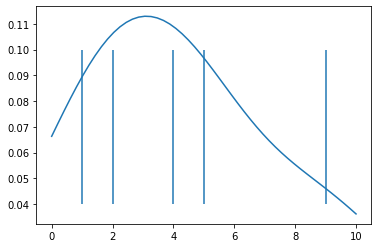

In [14]:
import numpy as np
import matplotlib.pyplot as plt
plt.vlines([1,2,4,5,9],ymin=0.04,ymax=0.1)
plt.plot(np.linspace(0,10),sp.stats.gaussian_kde([1,2,4,5,9])(np.linspace(0,10)))

\begin{equation}
\log L(\mathcal T;\nu,\alpha,\beta,B) \approx \sum_{e}\left(\left(\sum_{j}B_{0,j} \delta_{e,e_j}\log(\nu_ek_e(t_j))\right) -\nu_e\left(\int_0^T k_e(t)dt\right) + \sum_{e'} \left(\log(\alpha_{e',e}) \left(\sum_{j}\sum_{i>0} B_{i,j}\delta_{e',e_i}\delta_{e,e_j}\right) + \beta_{e',e} \left(\sum_{j}\sum_{i>0} B_{i,j}(t_i-t_j)\delta_{e',e_i}\delta_{e,e_j}\right)- \frac{\alpha_{e',e}}{\beta_{e',e}}\sum_i \delta_{e',e_i}\right)\right) \\
= \sum_{e}\left(\left(\sum_{j}B_{0,j} \delta_{e,e_j}\log(k_e(t_j))\right) + \left(\sum_{j}B_{0,j} \delta_{e,e_j}\log(\nu_e)\right) -\nu_eT + \sum_{e'} \left(\log(\alpha_{e',e}) \left(\sum_{j}\sum_{i>0} B_{i,j}\delta_{e',e_i}\delta_{e,e_j}\right) + \beta_{e',e} \left(\sum_{j}\sum_{i>0} B_{i,j}(t_i-t_j)\delta_{e',e_i}\delta_{e,e_j}\right)- \frac{\alpha_{e',e}}{\beta_{e',e}}\sum_i \delta_{e',e_i}\right)\right)
\end{equation}

where $k_e$ is a smoothing function normalised to integrate to $1$ over the interval $[0,T]$ (e.g. a KDE fit to events of type $e$ weighted by $B_{0,\cdot}$ and divided by its integral from $0$ to $T$) and
\begin{equation}
B_{i,j} = \frac{1}{\lambda_{e_j}(t_j)} \cdot \begin{cases}\alpha_{e_i,e_j}\exp(-\beta_{e_i,e_j}(t_j-t_i)), & i>0\\ \nu_{e_j}(t_j)k_{e_j}(t_j), & i=0\end{cases}
\end{equation}

so
\begin{equation}
\nu_e = \frac{\sum_{j}B_{0,j} \delta_{e,e_j}}{T} \\
\alpha_{e',e} = -\frac{\left(\sum_{j}\sum_{i>0} B_{i,j}\delta_{e',e_i}\delta_{e,e_j}\right)^2}{\left(\sum_i \delta_{e',e_i}\right)\left(\sum_{j}\sum_{i>0} B_{i,j}(t_i-t_j)\delta_{e',e_i}\delta_{e,e_j}\right)} \\
\beta_{e',e} = -\frac{\sum_{j}\sum_{i>0} B_{i,j}\delta_{e',e_i}\delta_{e,e_j}}{\sum_{j}\sum_{i>0} B_{i,j}(t_i-t_j)\delta_{e',e_i}\delta_{e,e_j}}.
\end{equation}

In [60]:
import jax
import jax.numpy as jnp
import numpy as np
import scipy as sp
import scipy.optimize
import tqdm
def em(times, events, T=None, iters=100, verbose=False, fit_kde=True):
    assert len(times) == len(events), (len(times),len(events))
    times = times.copy() - times[0]
    if T is None:
        T = times[-1]
    N_T = len(times)
    num_event_types = len(set(events))
    
    event_type_count = np.zeros(num_event_types)
    for e in events:
        event_type_count[e] += 1
        
    nu = np.ones(num_event_types)
    alpha = np.ones((num_event_types,num_event_types))
    beta = 2*np.ones((num_event_types,num_event_types))
    k = [lambda t : 1/T for _ in range(num_event_types)]
    
    for iteration in tqdm.trange(iters) if verbose else range(iters):
        #E step
        sum_j_B_0_j = np.zeros(num_event_types)
        sum_j_sum_i_B_i_j = np.zeros((num_event_types,num_event_types))
        forwards_pass = np.zeros((num_event_types,num_event_types))
        backwards_pass = np.zeros((num_event_types,num_event_types))
        
        intensities = np.zeros_like(times)
        endo_intensity = np.zeros((num_event_types,num_event_types))
        prev_t = 0
        if fit_kde:
            times_by_event_type = [[] for _ in range(num_event_types)]
            kde_weights = [[] for _ in range(num_event_types)]
        for j,(t,e) in enumerate(zip(times,events)):
            endo_intensity *= np.exp(-beta*(t-prev_t))
            intensities[j] = nu[e]*k[e](t)+endo_intensity[:,e].sum()
            B_0_j = nu[e]*k[e](t)/intensities[j]
            if fit_kde:
                times_by_event_type[e].append(t)
                kde_weights[e].append(B_0_j)
            sum_j_B_0_j[e] += B_0_j
            sum_i_B_i_j = endo_intensity[:,e]/intensities[j]
            sum_j_sum_i_B_i_j[:,e] += sum_i_B_i_j
            forwards_pass[:,e] += t*sum_i_B_i_j
            endo_intensity[e,:] += alpha[e,:]
            prev_t = t

        sum_j_B_i_j = np.zeros((num_event_types,num_event_types))
        next_t = T
        for i,(t,e) in reversed(list(enumerate(zip(times,events)))):
            sum_j_B_i_j *= np.exp(-beta*(next_t-t))
            backwards_pass[e,:] += t*sum_j_B_i_j[e,:]
            sum_j_B_i_j[:,e] += alpha[:,e]/intensities[i]
            next_t = t
            
        #M step
#         def partial_ll(log_nu,log_alpha,log_beta):
#             return log_nu*(sum_j_B_0_j) + log_alpha*sum_j_sum_i_B_i_j + jnp.exp(log_beta)*(backwards_pass-forwards_pass) - jnp.exp(log_nu)*T - jnp.exp(log_alpha-log_beta)*N_T
        
#         print(sum_j_B_0_j, sum_j_sum_i_B_i_j, backwards_pass, forwards_pass, T, N_T)
        
#         starting_partial_ll = partial_ll(log_nu,log_alpha,log_beta)
#         def loss(params):
#             return -partial_ll(*params)/starting_partial_ll
        
#         print(intensities)
#         print(loss([log_nu,log_alpha,log_beta]))
#         print(jax.grad(loss)([log_nu,log_alpha,log_beta]))
#         print(log_nu,log_alpha,log_beta)
        
        
#         constraint = sp.optimize.LinearConstraint([[0,-1,1]], lb=[0], ub=[np.inf], keep_feasible=False)
#         sol=sp.optimize.minimize(loss, jac=jax.grad(loss), x0=[log_nu,log_alpha,log_beta], constraints=constraint, method='trust-constr',options=dict(maxiter=2))
#         print(sol)
#         log_nu,log_alpha,log_beta = sol.x
        beta_coef = backwards_pass-forwards_pass
        #assert np.all(beta_coef<0), (beta_coef,beta_coef.max())
        
        nu = sum_j_B_0_j/T
        alpha = np.nan_to_num(np.where(beta_coef<0,-sum_j_sum_i_B_i_j**2/(event_type_count*beta_coef),0))
        beta = np.nan_to_num(np.where(beta_coef<0,-sum_j_sum_i_B_i_j/beta_coef,0))
        beta = beta.clip(alpha,np.inf)
        if fit_kde: #kde is expensive
            kdes = [sp.stats.gaussian_kde(times_by_event_type[e],weights=kde_weights[e]) for e in range(num_event_types)]
            k = [lambda t : kdes[e](t).squeeze()/kdes[e].integrate_box_1d(0,T) for e in range(num_event_types)]
        if verbose:
            print(nu,alpha,beta)
            plt.imshow(alpha/beta)
            plt.show()
        
    return nu,alpha,beta

ERROR! Session/line number was not unique in database. History logging moved to new session 1263


  0%|                                                                                                                                                                                                                                                                                               | 0/30 [00:00<?, ?it/s]

[0.00322935 0.00630355] [[0.94684767 0.86815416]
 [0.96382753 1.10705181]] [[1.94436551 1.89067296]
 [1.88292404 2.05479456]]


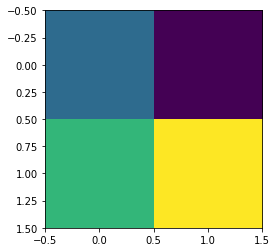


  3%|█████████▎                                                                                                                                                                                                                                                                             | 1/30 [00:02<01:21,  2.82s/it]

[1.00065686e-05 2.03451034e-03] [[0.90974647 0.77121692]
 [0.93348677 1.19430467]] [[1.9103548  1.79445761]
 [1.78221892 2.09689455]]


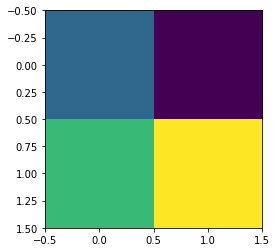


  7%|██████████████████▌                                                                                                                                                                                                                                                                    | 2/30 [00:05<01:16,  2.73s/it]

[2.96549592e-08 2.01290740e-03] [[0.883123   0.69614154]
 [0.90580028 1.26383815]] [[1.8960845  1.70848009]
 [1.69549771 2.13529274]]


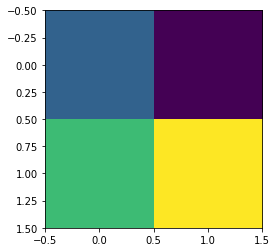


 10%|███████████████████████████▉                                                                                                                                                                                                                                                           | 3/30 [00:08<01:12,  2.69s/it]

[8.50423904e-11 2.01295431e-03] [[0.86557294 0.6372538 ]
 [0.88079439 1.32057289]] [[1.89835351 1.62935508]
 [1.61898778 2.17115577]]


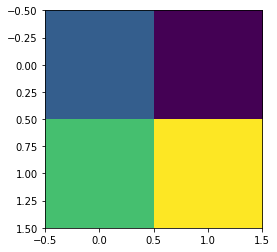


 13%|█████████████████████████████████████▏                                                                                                                                                                                                                                                 | 4/30 [00:11<01:12,  2.78s/it]

[2.37659891e-13 2.01313312e-03] [[0.8555073  0.58991571]
 [0.8577464  1.36767294]] [[1.91527345 1.555039  ]
 [1.55017114 2.205976  ]]


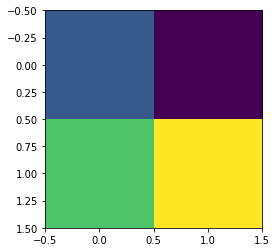


  1%|██▊                                                                                                                                                                                                                                                                                | 1/100 [01:58<3:15:41, 118.60s/it]


[6.50375022e-16 2.01332171e-03] [[0.85189884 0.55091501]
 [0.83616021 1.4079263 ]] [[1.94581511 1.48422572]
 [1.48732879 2.24133989]]


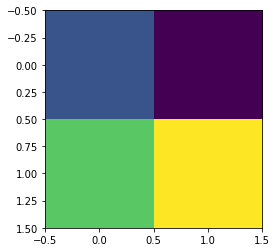


 20%|███████████████████████████████████████████████████████▊                                                                                                                                                                                                                               | 6/30 [00:18<01:20,  3.34s/it]

[1.74886492e-18 2.01351025e-03] [[0.85409226 0.51798555]
 [0.81569533 1.44371354]] [[1.9895369  1.41602364]
 [1.42926911 2.27880446]]


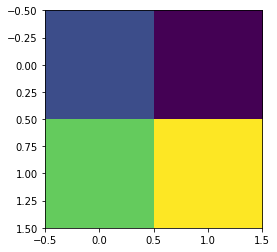


 23%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 7/30 [00:21<01:18,  3.40s/it]

[4.63261621e-21 2.01368288e-03] [[0.86168631 0.48950241]
 [0.79611997 1.47704259]] [[2.04641544 1.34978635]
 [1.37516007 2.31987363]]


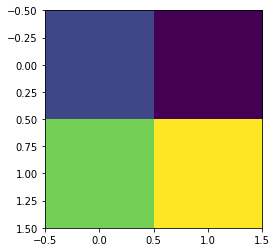


 27%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 8/30 [00:25<01:14,  3.40s/it]

[1.21113041e-23 2.01380828e-03] [[0.87445772 0.46428587]
 [0.77728    1.50961934]] [[2.11673225 1.28503086]
 [1.32442033 2.36602836]]


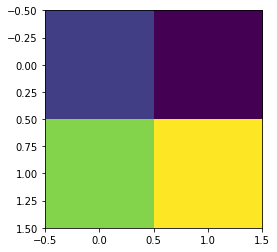


 30%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                   | 9/30 [00:27<01:07,  3.22s/it]

[3.12947643e-26 2.01383261e-03] [[0.89230865 0.44147842]
 [0.75907765 1.54292275]] [[2.20099063 1.22141953]
 [1.27664538 2.41876965]]


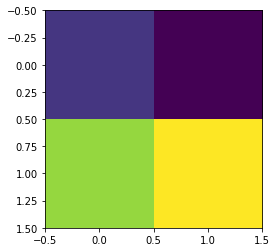


 33%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                         | 10/30 [00:31<01:02,  3.14s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/5l/jdr1h_pn3x3_7nt8kgthzmv00000gn/T/ipykernel_1171/2490250521.py", line 8, in <module>
    samples = [em(*model.simulate(0,500)[:2],iters=30,verbose=True) for _ in tqdm.trange(100,position=0,leave=True)]
  File "/var/folders/5l/jdr1h_pn3x3_7nt8kgthzmv00000gn/T/ipykernel_1171/2490250521.py", line 8, in <listcomp>
    samples = [em(*model.simulate(0,500)[:2],iters=30,verbose=True) for _ in tqdm.trange(100,position=0,leave=True)]
  File "/var/folders/5l/jdr1h_pn3x3_7nt8kgthzmv00000gn/T/ipykernel_1171/2118364473.py", line 24, in em
    for iteration in tqdm.trange(iters) if verbose else range(iters):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/std.py", line 1190, in __iter__
    self.update(n -


KeyboardInterrupt



In [59]:
model = mpoints.hybrid_hawkes_exp.HybridHawkesExp(2,1,[0,1],[0])
nu = np.array([1,1],dtype=np.float64)
alpha = np.array([[[2,1]],[[1,3]]],dtype=np.float64)
beta = np.array([[[6,3]],[[3,9]]],dtype=np.float64)
model.set_hawkes_parameters(nu,alpha,beta)
model.set_transition_probabilities(np.array([[[1],[1]]],dtype=np.float64))

samples = [em(*model.simulate(0,500)[:2],iters=30) for _ in tqdm.trange(100,position=0,leave=True)]
nus,alphas,betas = map(lambda x : np.quantile(x,[0.025,0.5,0.975],axis=0),map(np.array,zip(*samples)))

for x,y in list(zip(nus.reshape(3,-1).T,model.base_rates.reshape(-1))) + list(zip(alphas.reshape(3,-1).T,model.impact_coefficients.reshape(-1))) + list(zip(betas.reshape(3,-1).T,model.decay_coefficients.reshape(-1))):
    print(x,y)

# Multi-Kernel

\begin{equation}
\log L(\mathcal T;\nu,\alpha,\beta,B) \approx \sum_{e}\left(\log(\nu_e) \left(\sum_{j}B_{0,j} \delta_{e,e_j}\right) + \sum_{e'} \left(\log(\alpha_{e',e,K}) \left(\sum_{j}\sum_{i>0} B_{i,j,K}\delta_{e',e_i}\delta_{e,e_j}\right) + \beta_{e',e,K} \left(\sum_{j}\sum_{i>0} B_{i,j_K}(t_i-t_j)\delta_{e',e_i}\delta_{e,e_j}\right) -\nu_e (T)- \frac{\alpha_{e',e,K}}{\beta_{e',e,K}}\sum_i \delta_{e',e_i}\right)\right)
\end{equation}

\begin{equation}
\log L(\mathcal T;\nu,\alpha,\beta,B) = \sum_{t\in \mathcal T}\log\lambda(t) - \int_0^T \lambda(t)dt
\\= \sum_{j}B_{0,j}\log\nu + \sum_{j}\sum_{i>0} B_{i,j,K} \left(\log(\alpha_K) + \beta_K (t_i-t_j)\right) - T\nu - \sum_{t\in\mathcal T} \int_t^T \alpha_K\exp\left(-\beta_K(s-t)\right)ds
\\= \sum_{j}B_{0,j}\log\nu + \sum_{j}\sum_{i>0} B_{i,j,K} \left(\log(\alpha_K) + \beta_K (t_i-t_j)\right) - T\nu - \sum_{t\in\mathcal T} \left[-\frac{\alpha_K}{\beta_K}\exp\left(-\beta_K(s-t)\right)\right]_t^T
\\= \sum_{j}B_{0,j}\log\nu + \sum_{j}\sum_{i>0} B_{i,j,K} \left(\log(\alpha_K) + \beta_K (t_i-t_j)\right) - T\nu + \frac{\alpha_K}{\beta}\sum_{t\in\mathcal T} \left[\exp\left(-\beta_K(s-t)\right)\right]_t^T
\\\approx \sum_{j}B_{0,j}\log\nu + \sum_{j}\sum_{i>0} B_{i,j,K} \left(\log(\alpha_K) + \beta_K (t_i-t_j)\right) - T\nu - \frac{\alpha_K}{\beta_K}N_T \text{ (quasi-EM approximation)}
\\= \log(\nu) \left(\sum_{j}B_{0,j}\right) + \log(\alpha_K) \left(\sum_{j}\sum_{i>0} B_{i,j,K}\right) + \beta_K \left(\sum_{j}\sum_{i>0} B_{i,j,K}(t_i-t_j)\right) -\nu (T)- \frac{\alpha_K}{\beta_K}\left(N_T\right)
\end{equation}

where
\begin{equation}
B_{i,j} = \frac{1}{\lambda(t_j)} \cdot \begin{cases}\alpha\exp(-\beta(t_j-t_i)), & i>0\\ \nu, & i=0\end{cases}
\end{equation}

implying

\begin{equation}
\nu = \frac{\sum_{j}B_{0,j}}{T} \\
\frac{\alpha}{\beta} = \frac{\sum_{j}\sum_{i>0} B_{i,j}}{N_T} \\
\frac{\alpha}{\beta^2} = -\frac{\sum_{j}\sum_{i>0} B_{i,j}(t_i-t_j)}{N_T}
\end{equation}

i.e.

\begin{equation}
\nu = \frac{\sum_{j}B_{0,j}}{T} \\
\beta = -\frac{\sum_{j}\sum_{i>0} B_{i,j}}{\sum_{j}\sum_{i>0} B_{i,j}(t_i-t_j)} \\
\alpha = -\frac{\left(\sum_{j}\sum_{i>0} B_{i,j}\right)^2}{N_T\sum_{j}\sum_{i>0} B_{i,j}(t_i-t_j)}
\end{equation}


# State-Dependent

\begin{equation}
\log L(\mathcal T;\nu,\alpha,\beta,B) \approx \sum_{e}\left(\log(\nu_e) \left(\sum_{j}B_{0,j} \delta_{e,e_j}\right) + \sum_{e'} \left(\log(\alpha_{e',e}) \left(\sum_{j}\sum_{i>0} B_{i,j}\delta_{e',e_i}\delta_{e,e_j}\right) + \beta_{e',e} \left(\sum_{j}\sum_{i>0} B_{i,j}(t_i-t_j)\delta_{e',e_i}\delta_{e,e_j}\right) -\nu_e (T)- \frac{\alpha_{e',e}}{\beta_{e',e}}\sum_i \delta_{e',e_i}\right)\right)
\end{equation}

where
\begin{equation}
B_{i,j} = \frac{1}{\lambda_{e_j}(t_j)} \cdot \begin{cases}\alpha_{e_i,e_j}\exp(-\beta_{e_i,e_j}(t_j-t_i)), & i>0\\ \nu_{e_j}, & i=0\end{cases}
\end{equation}

# Non-Monotonic

\begin{equation}
\log L(\mathcal T;\nu,\alpha,\beta,B) = \sum_{t\in \mathcal T}\log\lambda(t) - \int_0^T \lambda(t)dt
\\= \sum_{j}B_{0,j}\log\nu + \sum_{j}\sum_{i>0} B_{i,j} \left(\log(\alpha) + \beta (t_i-t_j) - \gamma(t_i-t_j)^2\right) - T\nu - \sum_{t\in\mathcal T} \int_t^T \alpha\exp\left(-\beta(s-t)-\gamma(s-t)^2\right)ds
\\= \sum_{j}B_{0,j}\log\nu + \sum_{j}\sum_{i>0} B_{i,j} \left(\log(\alpha) + \beta (t_i-t_j) - \gamma(t_i-t_j)^2\right) - T\nu - \sum_{t\in\mathcal T} \int_t^T \alpha\exp\left(-\gamma\left(\frac{2\beta}{2\gamma}(s-t)+(s-t)^2\right)\right)ds
\\= \sum_{j}B_{0,j}\log\nu + \sum_{j}\sum_{i>0} B_{i,j} \left(\log(\alpha) + \beta (t_i-t_j) - \gamma(t_i-t_j)^2\right) - T\nu - \sum_{t\in\mathcal T} \int_t^T \alpha\exp\left(-\gamma\left(\frac{2\beta}{2\gamma}(s-t)+(s-t)^2+\left(\frac{\beta}{2\gamma}\right)^2-\left(\frac{\beta}{2\gamma}\right)^2\right)\right)ds
\\= \sum_{j}B_{0,j}\log\nu + \sum_{j}\sum_{i>0} B_{i,j} \left(\log(\alpha) + \beta (t_i-t_j) - \gamma(t_i-t_j)^2\right) - T\nu - \sum_{t\in\mathcal T} \int_t^T \alpha\exp\left(-\gamma\left(\left(s-t+\frac{\beta}{2\gamma}\right)^2-\left(\frac{\beta}{2\gamma}\right)^2\right)\right)ds
\\= \sum_{j}B_{0,j}\log\nu + \sum_{j}\sum_{i>0} B_{i,j} \left(\log(\alpha) + \beta (t_i-t_j) - \gamma(t_i-t_j)^2\right) - T\nu - \sum_{t\in\mathcal T} \int_t^T \alpha\exp\left(-\gamma\left(s-t+\frac{\beta}{2\gamma}\right)^2+\frac{\beta^2}{4\gamma}\right)ds
\\= \sum_{j}B_{0,j}\log\nu + \sum_{j}\sum_{i>0} B_{i,j} \left(\log(\alpha) + \beta (t_i-t_j) - \gamma(t_i-t_j)^2\right) - T\nu - \sum_{t\in\mathcal T} \int_t^T \alpha\exp\left(-\left(\sqrt{\gamma}(s-t)+\frac{\beta}{2\sqrt{\gamma}}\right)^2+\frac{\beta^2}{4\gamma}\right)ds
\\= \sum_{j}B_{0,j}\log\nu + \sum_{j}\sum_{i>0} B_{i,j} \left(\log(\alpha) + \beta (t_i-t_j) - \gamma(t_i-t_j)^2\right) - T\nu - \sum_{t\in\mathcal T} \int_t^T \alpha\exp\left(-\frac{1}{2}\left(\sqrt{2\gamma}(s-t)+\frac{\beta}{\sqrt{2\gamma}}\right)^2+\frac{\beta^2}{4\gamma}\right)ds
\\= \sum_{j}B_{0,j}\log\nu + \sum_{j}\sum_{i>0} B_{i,j} \left(\log(\alpha) + \beta (t_i-t_j) - \gamma(t_i-t_j)^2\right) - T\nu - \alpha\exp\left(\frac{\beta^2}{4\gamma}\right)\sqrt{\frac{\pi}{\gamma}}\sum_{t\in\mathcal T} \left(\Phi\left(\sqrt{2\gamma}(T-t)+\frac{\beta}{\sqrt{2\gamma}}\right)-\Phi\left(\frac{\beta}{\sqrt{2\gamma}}\right)\right)
\\\approx \log(\nu) \left(\sum_{j}B_{0,j}\right) + \log(\alpha) \left(\sum_{j}\sum_{i>0} B_{i,j}\right) + \beta \left(\sum_{j}\sum_{i>0} B_{i,j}(t_i-t_j)\right) - \gamma \left(\sum_{j}\sum_{i>0} B_{i,j}(t_i-t_j)^2\right) -\nu (T)- \alpha\exp\left(\frac{\beta^2}{4\gamma}\right)\sqrt{\frac{\pi}{\gamma}}\left(1-\Phi\left(\frac{\beta}{\sqrt{2\gamma}}\right)\right)N_T
\\= \log(\nu) \left(\sum_{j}B_{0,j}\right) + \log(\alpha) \left(\sum_{j}\sum_{i>0} B_{i,j}\right) + \beta \left(\sum_{j}\sum_{i>0} B_{i,j}(t_i-t_j)\right) - \gamma \left(\sum_{j}\sum_{i>0} B_{i,j}t_i^2 + \sum_{j}t_j^2\sum_{i>0} B_{i,j} - 2\sum_{j}t_j\sum_{i>0} B_{i,j}t_i\right) -\nu (T)- \alpha\exp\left(\frac{\beta^2}{4\gamma}\right)\sqrt{\frac{\pi}{\gamma}}\left(1-\Phi\left(\frac{\beta}{\sqrt{2\gamma}}\right)\right)N_T
\end{equation}

where
\begin{equation}
B_{i,j} = \frac{1}{\lambda(t_j)} \cdot \begin{cases}\alpha\exp(-\beta(t_j-t_i) - \gamma(t_j-t_i)^2), & i>0\\ \nu, & i=0\end{cases}
\\ = \frac{1}{\lambda(t_j)} \cdot \begin{cases}\alpha\exp(-\beta(t_j-t_k+t_k-t_i) - \gamma(t_j-t_k+t_k-t_i)^2), & i>0\\ \nu, & i=0\end{cases}
\\ = \frac{1}{\lambda(t_j)} \cdot \begin{cases}\alpha\exp(-\beta(t_j-t_k+t_k-t_i) - \gamma((t_j-t_k)^2+(t_k-t_i)^2+2(t_j-t_k)(t_k-t_i))), & i>0\\ \nu, & i=0\end{cases}
\\ = \frac{1}{\lambda(t_j)} \cdot \begin{cases}\alpha\exp(-\beta(t_j-t_k))\exp(-\gamma(t_j-t_k)^2)\exp(- \gamma(t_k-t_i))^{2(t_j-t_k)}\exp(-\beta(t_k-t_i))\exp(-\gamma(t_k-t_i)^2), & i>0\\ \nu, & i=0\end{cases}
\end{equation}

\begin{equation}
\log L(\mathcal T;\nu,\alpha,\beta,B) = \sum_{t\in \mathcal T}\log\lambda(t) - \int_0^T \lambda(t)dt
\\= \sum_{j}\sum_{i>0} B_{i,j} \left(\log(\alpha) - \frac{1}{2} \left(\frac{t_j-t_i-\mu}{\sigma}\right)^2\right) - \sum_{t\in\mathcal T} \int_t^T \alpha\exp\left(- \frac{1}{2} \left(\frac{s-t-\mu}{\sigma}\right)^2\right)ds
\\= \sum_{j}\sum_{i>0} B_{i,j} \left(\log(\alpha) - \frac{1}{2} \left(\frac{t_j-t_i-\mu}{\sigma}\right)^2\right) - \alpha\sigma\sqrt{2\pi}\sum_{t\in\mathcal T} \left(1-\Phi\left(\frac{-\mu}{\sigma}\right)\right)
\\= \sum_{j}\sum_{i>0} B_{i,j} \left(\log(\alpha) - \frac{1}{2} \left(\frac{t_j-t_i-\mu}{\sigma}\right)^2\right) - \alpha\sigma\sqrt{2\pi}N_T \Phi\left(\frac{\mu}{\sigma}\right)
\\= \sum_{j}\sum_{i>0} B_{i,j} \left(\log(\alpha) -\frac{1}{2\sigma^2}t_j^2-\frac{1}{2\sigma^2}t_i^2-\frac{1}{2\sigma^2}\mu^2+\frac{1}{\sigma^2}t_j\mu-\frac{1}{\sigma^2}t_i\mu+\frac{1}{\sigma^2}t_jt_i\right) - \alpha\sigma\sqrt{2\pi}N_T \Phi\left(\frac{\mu}{\sigma}\right)
\\= \left(\sum_{j}\sum_{i>0} B_{i,j} \log(\alpha) -\sum_{j}\sum_{i>0} B_{i,j} \frac{1}{2\sigma^2}t_j^2-\sum_{j}\sum_{i>0} B_{i,j} \frac{1}{2\sigma^2}t_i^2-\sum_{j}\sum_{i>0} B_{i,j} \frac{1}{2\sigma^2}\mu^2+\sum_{j}\sum_{i>0} B_{i,j} \frac{1}{\sigma^2}t_j\mu-\sum_{j}\sum_{i>0} B_{i,j} \frac{1}{\sigma^2}t_i\mu+\sum_{j}\sum_{i>0} B_{i,j} \frac{1}{\sigma^2}t_jt_i\right) - \alpha\sigma\sqrt{2\pi}N_T \Phi\left(\frac{\mu}{\sigma}\right)
\\= \log(\alpha)\sum_{j}\sum_{i>0} B_{i,j} -\frac{1}{2\sigma^2}\sum_{j}t_j^2\sum_{i>0} B_{i,j} -\sum_{j}\sum_{i>0} B_{i,j} \frac{1}{2\sigma^2}t_i^2-\sum_{j}\sum_{i>0} B_{i,j} \frac{1}{2\sigma^2}\mu^2+\sum_{j}\sum_{i>0} B_{i,j} \frac{1}{\sigma^2}t_j\mu-\sum_{j}\sum_{i>0} B_{i,j} \frac{1}{\sigma^2}t_i\mu+\sum_{j}\sum_{i>0} B_{i,j} \frac{1}{\sigma^2}t_jt_i - \alpha\sigma\sqrt{2\pi}N_T \Phi\left(\frac{\mu}{\sigma}\right)
\end{equation}

where
\begin{equation}
B_{i,j} = \frac{1}{\lambda(t_i)} \alpha\exp\left(- \frac{1}{2} \left(\frac{t_j-t_i-\mu}{\sigma}\right)^2\right)
\end{equation}


In [ ]:
sp.special.erf((2)/(2*np.sqrt(gamma)))

In [180]:
import sympy
alpha = sympy.Symbol('alpha')
beta = sympy.Symbol('beta')
gamma = sympy.Symbol('gamma')
t = sympy.Symbol('t')
integral = (alpha*sympy.exp(-abs(beta)*t-abs(gamma)*t**2)).integrate(t)
integral.subs(t,sympy.oo) - integral

-alpha*Piecewise((sqrt(pi)*exp(Abs(beta)**2/(4*Abs(gamma)))*erf((2*t*Abs(gamma) + Abs(beta))/(2*sqrt(Abs(gamma))))/(2*sqrt(Abs(gamma))), Abs(gamma) > 0), (-sqrt(pi)*sqrt(-1/Abs(gamma))*exp(Abs(beta)**2/(4*Abs(gamma)))*erfi(I*(-2*t*Abs(gamma) - Abs(beta))/(2*sqrt(Abs(gamma))))/2, True)) + alpha*Piecewise((sqrt(pi)*exp(Abs(beta)**2/(4*Abs(gamma)))*erf((Abs(beta) + oo*Abs(gamma))/(2*sqrt(Abs(gamma))))/(2*sqrt(Abs(gamma))), Abs(gamma) > 0), (-sqrt(pi)*sqrt(-1/Abs(gamma))*exp(Abs(beta)**2/(4*Abs(gamma)))*erfi(I*(-Abs(beta) - oo*Abs(gamma))/(2*sqrt(Abs(gamma))))/2, True))

In [184]:
(alpha*sympy.sqrt(sympy.pi/gamma)*sympy.exp(beta**2 / (4*gamma))/2 - integral)

sqrt(pi)*alpha*sqrt(1/gamma)*exp(beta**2/(4*gamma))/2 - alpha*Piecewise((sqrt(pi)*exp(Abs(beta)**2/(4*Abs(gamma)))*erf((2*t*Abs(gamma) + Abs(beta))/(2*sqrt(Abs(gamma))))/(2*sqrt(Abs(gamma))), Abs(gamma) > 0), (-sqrt(pi)*sqrt(-1/Abs(gamma))*exp(Abs(beta)**2/(4*Abs(gamma)))*erfi(I*(-2*t*Abs(gamma) - Abs(beta))/(2*sqrt(Abs(gamma))))/2, True))

# Simulation

## Multivariate State-Dependent Hawkes

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import sys
sys.path.append('../code/')
import fast_em_classes
import cProfile

hello


In [3]:
def simulate(exo_intensity, alpha, beta, transition, start_time=0,end_time=500):
    num_event_types = alpha.shape[0]
    num_states = alpha.shape[2]
    
    prev_time = start_time
    endo_intensity = np.zeros_like(alpha)
    times = []
    events = []
    states = []
    state = 0
    while True:
        intensity_upper_bound = exo_intensity + endo_intensity[:,:,state].sum(axis=0)
        time = prev_time + np.random.exponential(1/intensity_upper_bound.sum())
        if time>end_time:
            break
        endo_intensity *= np.exp(-beta * (time-prev_time))
        intensity = exo_intensity + endo_intensity[:,:,state].sum(axis=0)
        if np.random.uniform() * intensity_upper_bound.sum() < intensity.sum():
            times.append(time)
            assert len(intensity.shape) == 1
            event = np.random.choice(np.arange(num_event_types),p=intensity/intensity.sum())
            events.append(event)
            state = np.random.choice(np.arange(num_states),p=transition[state,event,:])
            states.append(state)
            endo_intensity[event,:,state] += alpha[event,:,state]
        prev_time = time
    return np.array(times),np.array(events),np.array(states)

In [6]:
nu = np.array([4,5],dtype=np.float64)
alpha = np.array([[[1,9],[2,6]],[[3,9],[4,8]]],dtype=np.float64)
beta = np.array([[[5,11],[6,9]],[[7,10],[8,15]]],dtype=np.float64)
transition = np.array([[[0,1],[0.3,0.7]],[[0.1,0.9],[0.6,0.4]]],dtype=np.float64)


In [ ]:
results = []
for _ in tqdm.trange(100):
    print('simulating')
    times, events, states = simulate(nu, alpha, beta, transition, 0,5)
    print('setting up kernel')
    kernel = fast_em_classes.CompositeKernel([fast_em_classes.ExponentialHawkesKernel(alpha,beta),fast_em_classes.ConstantKernel(nu)])
    print('running em')
    kernel.em(0,5,times,events,states)#cProfile.run('kernel.em(0,500,times,events,states)')
    print('recording results')
    results.append(kernel.get_params())

  0%|                                                                                                                                                                                                                 | 0/100 [00:00<?, ?it/s]

simulating
setting up kernel
running em
getting intensities


## Inhomogenous Univariate Hawkes

In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import sympy

In [128]:
np.mean([exo_intensity(i) for i in range(500)])

0.23779963785636068

In [1]:
def exo_intensity(t):
    return 3*(t/500)
    #return 3*np.exp(-(t-250)**2/500)

def simulate(exo_intensity=exo_intensity, exo_intensity_upper_bound=3, alpha=10, beta=21, start_time=0,end_time=500):
    prev_time = start_time
    endo_intensity = 0
    times = []
    exo = []
    endo = []
    while True:
        intensity_upper_bound = exo_intensity_upper_bound + endo_intensity
        time = prev_time + np.random.exponential(1/intensity_upper_bound)
        if time>end_time:
            break
        endo_intensity *= np.exp(-beta * (time-prev_time))
        if np.random.uniform() * intensity_upper_bound < exo_intensity(time) + endo_intensity:
            times.append(time)
            exo.append(exo_intensity(time))
            endo.append(endo_intensity)
            endo_intensity += alpha
        prev_time = time
    return np.array(times),np.array(exo),np.array(endo)

In [11]:
times,exo,endo = simulate()

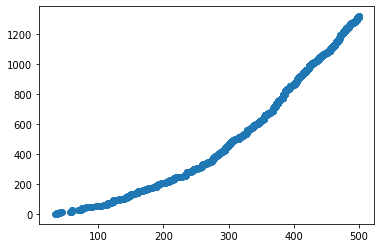

In [134]:
plt.scatter(times,np.arange(len(times)))

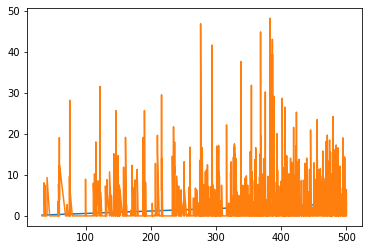

In [135]:
plt.plot(times,exo)
plt.plot(times,endo)

### KDE

In [136]:
import sys
sys.path.append('../code/')
import fast_em_classes

[[array([[9.54792769]]), array([[20.18475938]])], [array([1.39331772]), None]]

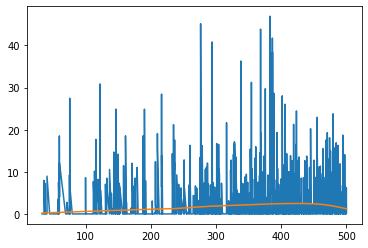

In [137]:
kernel = fast_em_classes.CompositeKernel([fast_em_classes.ExponentialHawkesKernel(1.0,1.0),fast_em_classes.SmoothingKernel(1.0)])

kernel.em(0,500,times)
endo,exo=kernel.get_component_intensities(0,500,times)
plt.plot(times,endo)
plt.plot(times,exo)
kernel.get_params()

### Reflected KDE

[[array([[9.54222841]]), array([[20.0385646]])], [array([1.38494515]), None]]

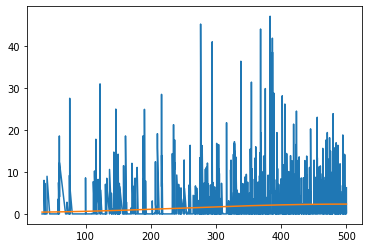

In [138]:
kernel = fast_em_classes.CompositeKernel([fast_em_classes.ExponentialHawkesKernel(1.0,1.0),fast_em_classes.ReflectedSmoothingKernel(1.0,frac_reflected=0.1)])

kernel.em(0,500,times)
endo,exo=kernel.get_component_intensities(0,500,times)
plt.plot(times,endo)
plt.plot(times,exo)
kernel.get_params()

### Constant

[[array([[8.89090904]]), array([[16.59175022]])], array([1.22717759])]

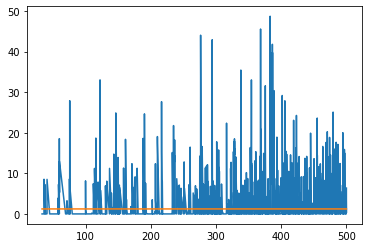

In [139]:
kernel = fast_em_classes.CompositeKernel([fast_em_classes.ExponentialHawkesKernel(1.0,1.0),fast_em_classes.ConstantKernel(1.0)])

kernel.em(0,500,times)
endo,exo=kernel.get_component_intensities(0,500,times)
plt.plot(times,endo)
plt.plot(times,exo)
kernel.get_params()

### Polynomial

[[array([[9.48207237]]), array([[20.20259915]])],
 [array([0.36742935]),
  array([3.1068344]),
  array([4.21493124e-166]),
  array([3.34239756e-07]),
  array([4.26821959e-270]),
  array([5.93048328e-13]),
  array([0.]),
  array([1.1447097e-17]),
  array([0.]),
  array([1.41770542e-21]),
  array([0.])]]

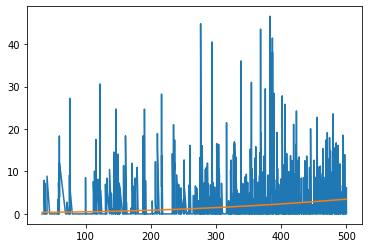

In [140]:
kernel = fast_em_classes.CompositeKernel([fast_em_classes.ExponentialHawkesKernel(1.0,1.0),fast_em_classes.PolynomialExogenousKernel(1.0,5)])

kernel.em(0,500,times)
endo,exo=kernel.get_component_intensities(0,500,times)
plt.plot(times,endo)
plt.plot(times,exo)
kernel.get_params()

In [141]:
exo.mean()*500

961.3804460625887

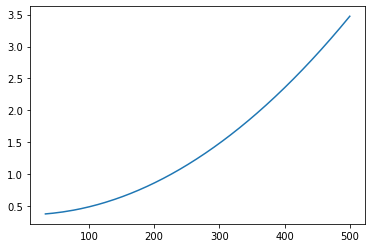

In [142]:
plt.plot(times,exo)

- State dependence & multivariate tests

$e^{-\beta_1t}$

$1 - e^{-\beta_2t}$

## Negative Intensity

In [42]:
prev_time = 0
endo_intensity = 0
negative_intensity = 0
times = []
while True:
    intensity_upper_bound = 3 + endo_intensity
    time = prev_time + np.random.exponential(1/intensity_upper_bound)
    if time>300:
        break
    endo_intensity *= np.exp(- (time-prev_time))
    negative_intensity *= np.exp(-2 * (time-prev_time))
    if np.random.uniform() * intensity_upper_bound < 3 + endo_intensity - negative_intensity:
        times.append(time)
        endo_intensity += 1
        negative_intensity -= 1
    prev_time = time
times = np.array(times)


KeyboardInterrupt



In [76]:
kernel = fast_em_classes.CompositeKernel([fast_em_classes.ExponentialHawkesKernel(1.0,1.0), fast_em_classes.ExponentialHawkesKernel(-1.0,2.0),fast_em_classes.ConstantKernel(1.0)])

In [77]:
kernel.em(0,10,np.log(1+np.linspace(0,10,10)))

components [ 1.0477909  -0.63463625  0.58684535]
components [ 1.4707079  -0.92313643  0.45242853]
components [ 1.76761261 -1.11634201  0.3487294 ]
components [ 1.93551005 -1.22289452  0.28738448]
components [ 2.02431969 -1.27868444  0.25436475]
components [ 2.07100348 -1.30796816  0.23696468]
components [ 2.09574365 -1.32351252  0.22776887]
components [ 2.10897558 -1.33184214  0.22286655]
components [ 2.11610938 -1.33633912  0.22022975]
components [ 2.11998162 -1.33878215  0.21880053]
components [ 2.12209548 -1.34011641  0.21802093]
components [ 2.12325487 -1.3408484   0.21759353]
components [ 2.12389319 -1.34125145  0.21735826]
components [ 2.12424569 -1.34147405  0.21722835]
components [ 2.12444083 -1.34159727  0.21715644]
components [ 2.12454905 -1.34166561  0.21711656]
components [ 2.12460916 -1.34170357  0.21709441]
components [ 2.12464258 -1.34172468  0.2170821 ]
components [ 2.12466118 -1.34173642  0.21707525]
components [ 2.12467153 -1.34174296  0.21707143]
components [ 2.12467

True

In [78]:
kernel.get_params()

[[array([[[4.88226852]]]), array([[[2.29788708]]])],
 [array([[[-3.08318267]]]), array([[[2.29788744]]])],
 array([0.2170693])]

In [ ]:
params=kernel.get_params()
plt.plot(sum([(params[i][0] * np.exp(-params[i][1]*np.linspace(0,10))).squeeze() for i in (0,1)]))